### Introduction

The 7-bag randomizer algorithm presents the 7 pieces in a random order, and then repeats. This is typically implemented as something analogous to a list which is literally shuffled every 7 pieces. Shuffling is a well-studied problem with known efficient algorithms such as the [Fisher-Yates shuffle](https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle). For small scales such as 7-bag's mere $7! = 5040$ possible permutations, you could even pre-compute all shuffles and then simply select bags at random.

The 7-bag randomizer has many desirable properties. The maximum piece drought size has an upper limit of 12, which is generally seen as a positive thing. However it comes at a cost: 7-bag is the lowest entropy randomizer algorithm to ever appear in a commercial Tetris game. Certain aspects of 7-bag are particularly controversial, such as the possibility of players use degenerate "card counting" strategies. Examples include a single-player solution that allows [playing forever](https://tetris.wiki/Playing_forever). Another is the use of [perfect clear openers](https://harddrop.com/wiki/Perfect_Clear_Opener) in competitive settings. Many people feel that card counting is not a fun/interesting skill and these strategies take away from the core improvisational appeal of the game.

This notebook explores an alternative implementation of the 7-bag algorithm as a Markov process. While this is computationally less efficient, it provides a new perspective on the algorithm which facilitates some interesting modifications. In particular, the Markov process is simplified by removing the bag index state and increasing the entropy, reducing the viability of card-counting strategies. This is done in a way that exactly preserves the distribution of expected piece drought intervals. The net result is an algorithm with higher entropy and which feels very similar except for the absence of card counting. Additional randomizer constructions are explored, sharing many essential features of 7-bag while increasingly deviating from it in order to further increase entropy and reduce the viability of degenerate strategies.


### Representation

My chosen representation of the randomizer state includes:

- the current bag index
- an ordered list of the 7 current drought interval sizes (increasing order)
- a mapping of each of the 7 piece types to their respective drought interval size

The bag index simply keeps track of how many elements have been removed from the bag. The first selection has 0 removed, meaning the will be 7 branching options. Next there are 6 branching options, etc.

The ordered list allows convenient indexing for piece selection. If you are at bag index $n$, then the first $n$ options (the smallest droughts ie. the most recently received pieces) are unavailable.  

The mapping is extra bookkeeping to translate from the ordered list to an actual piece type. It is only needed if you actually want to deal pieces (ie. implement this in a game). As I'm only interested in studying the randomizer's drought interval and entropy properties, adding this is unneccessary and it will not be included in the randomizer state.

In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import networkx as nx
import graphviz
import random
import copy
import csv
import string
import math
from collections import Counter

class State7Bag:
    'Holds the state of a 7-bag randomizer.'

    def __init__(self, bag_index=0, droughts=[x for x in range(7)]):
        self.bag_index = bag_index
        self.droughts = droughts

    def __str__(self):
        return "Randomizer State: " + str(self.__dict__)

    def name(self):
        return "Index = " + str(self.bag_index) + ",\nDroughts =\n" + str(
            self.droughts)

    def __deepcopy__(self, memo):
        return State7Bag(
            copy.deepcopy(self.bag_index, memo),
            copy.deepcopy(self.droughts, memo))

    def __hash__(self):
        return hash((self.bag_index, tuple(self.droughts)))

    def __eq__(self, other):
        return self.bag_index == other.bag_index and self.droughts == other.droughts

While it is possible to represent Markov systems as a matrix, our Markov system here is sparsely connected. At each transition, there are just 1 to 7 possible transitions (depending on the bag index). As there are many MANY more states than 7, this would result in an extremely [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). For this reason, rather than using a matrix I chose to use a [directed graph](https://en.wikipedia.org/wiki/Directed_graph) which is more practical for sparsely connected systems, especially as the number of states increases as in more complicated randomizer constructions. 

In our Markov system each node corresponds to a unique randomizer state as defined above, and each edges corresponds to a certain "pick", ie. which element of the drought-ordered list was selected. Note that by definition, for 7-bag each pick maps onto a unique drought size, whereas for different randomizers with different states this is not necessarily the case.

At the beginning of each bag, the state is always:  

```Randomizer State: {'bag_index': 0, 'droughts': [0, 1, 2, 3, 4, 5, 6]}```

To give an example with a couple loops around the bag:

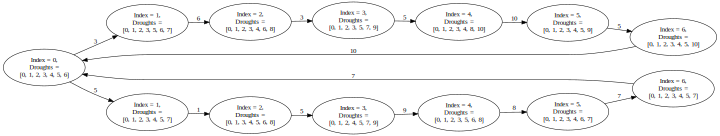

In [2]:
demo = nx.DiGraph()
old_state = State7Bag()

for i in range(2 * 7):
    roll = random.randrange(old_state.bag_index, 7)
    new_state = copy.deepcopy(old_state)
    new_state.bag_index = (new_state.bag_index + 1) % 7
    selection = new_state.droughts[roll]
    new_state.droughts = [drought + 1 for drought in new_state.droughts]
    new_state.droughts[roll] = 0
    new_state.droughts.sort()
    demo.add_edge(
        old_state,
        new_state,
        weight=1 / (7 - old_state.bag_index),
        drought=selection)
    old_state = copy.deepcopy(new_state)


def plot_graph(graph):
    viz = graphviz.Digraph()
    viz.attr(rankdir='LR', size='10')
    viz.attr('node', shape='oval')
    for from_node, to_node in graph.edges():
        viz.edge(
            from_node.name(),
            to_node.name(),
            label=str(graph.edges[from_node, to_node]['drought']))
    return viz


plot_graph(demo)

The numbers above the egdes represent the drought interval produced by the selected piece, and the drought list in the nodes represents a running total (ie. just a lower bound as opposed to the final/actualized droughts). You will note that after each selection there is a piece with a drought of 0, the most recently selected piece. The other drought intervals all grow larger by one.

### Full Contruction

The above graph illustrates just 2 possible trajectories through the 7-bag randomizer. There are far too many states to plot graphically, and it's probably best to systematically step through all the branching options systematically instead of randomly selecting them. So lets step through everything and see exactly what we're dealing with.

In [3]:
B7 = nx.DiGraph()
state_set = set()
state_work = list()

old_state = State7Bag()
state_work.append(old_state)

while len(state_work) > 0:
    # manage work queue
    old_state = copy.deepcopy(state_work[0])
    state_work.pop(0)
    state_set.add(old_state)
    # explore state transitions
    for roll in range(old_state.bag_index, 7):
        new_state = copy.deepcopy(old_state)
        new_state.bag_index += 1
        if (new_state.bag_index == 7):
            new_state.bag_index = 0
        drought = new_state.droughts[roll]
        new_state.droughts = [drought + 1 for drought in new_state.droughts]
        new_state.droughts[roll] = 0
        new_state.droughts.sort()
        B7.add_edge(
            old_state,
            new_state,
            drought=drought,
            weight=1 / (7 - old_state.bag_index))
        if (new_state not in state_set) and (new_state not in state_work):
            state_work.append(new_state)

print("Number of randomizer states (nodes):", len(B7))
print("Number of state transitions (edges):", len(B7.edges()))

Number of randomizer states (nodes): 127
Number of state transitions (edges): 448


That's a lot of nodes and edges! In matrix representation, we would expect it to be just $(1 - \frac{448}{127^2}) \approx 97\%$ empty.

### Verification

We should check to make sure this representation of 7-bag is correct. Let's see if we can recreate a known emergent quality of 7-bag, the symmetric pyramid drought interval distribution. This requires 2 steps:

- Calculate the stable state of the Markov system, giving us the % of the time the randomizer will be at each node (ie. the normalized [eigenvector](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of eigenvalue 1)
- Iterate over all the edges, grouping by drought interval and summing the stable proportion times the branching probability

Since each edge is equal to a particular drought value, we can simply sum all the weighted branching probabilities to get the overall drought interval distribution. In addition to visually inspecting the distribution, we can also do a sanity check that the drought interval probabilities sum to 1.

Another important thing to check is the entropy of the alorithm, this is known to be:

$-\sum \limits_{i=1}^7 \frac{1}{7} \times \log_7(\frac{1}{i}) \approx 62.59\%$

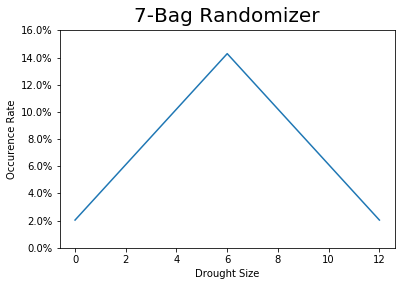

Number of randomizer states (nodes): 127
Number of state transitions (edges): 448
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.63
Branch Perplexity:  4.0
Drought Entropy (Base 13):  0.95
Drought Perplexity:  11.35



In [4]:
def get_eigenvector(G, weight=None, max_iter=50, tol=0):
    M = nx.to_scipy_sparse_matrix(
        G, nodelist=list(G), weight='weight', dtype=float)
    
    eigenvalue, eigenvector = sp.sparse.linalg.eigs(
        M.T, k=1, which='LR', maxiter=max_iter, tol=tol)
    eigenvector = eigenvector.flatten().real
    eigenvector = eigenvector / eigenvector.sum()

    stable = dict(zip(G, eigenvector))
    error = False
    for to_node in G:
        temp = 0
        for from_node in G.predecessors(to_node):
            temp += stable[from_node] * G.edges[from_node, to_node]['weight']
        if abs(stable[to_node] - temp) > 0.000001:
            error = True
    if error == True:
        print("ERROR: STABLE STATE IS NOT ACTUALLY STABLE")

    return stable


def get_drought_dist(graph, stable):
    drought_dist = Counter()
    for from_node, to_node in graph.edges():
        base_prob = stable[from_node]
        branch_prob = graph.edges[from_node, to_node]['weight']
        drought = graph.edges[from_node, to_node]['drought']
        drought_dist[drought] += base_prob * branch_prob
    return drought_dist


def get_entropy(graph, stable):
    entropy = 0
    perplexity = 0
    for from_node in graph:
        node_weight = stable[from_node]
        node_entropy = 0
        node_perplexity = 0
        for to_node in graph.neighbors(from_node):
            p = graph.edges[from_node, to_node]['weight']
            if p == 0:
                continue
            try:
                branch_entropy = -p * math.log(p, 2)
            except ValueError:
                # p ~= 0, attempted to take ~log(0)
                # by definition the entropy contribution for any p = 0 is 0
                branch_entropy = 0
            node_entropy += branch_entropy

        node_perplexity = 2**(node_entropy)
        entropy += node_weight * node_entropy
        perplexity += node_weight * node_perplexity
    return entropy, perplexity


def plot_counter(counter, name):
    keys = []
    values = []
    xlim = max(counter.keys())
    xlim = max([xlim, 12])
    for key in range(xlim + 1):
        keys.append(key)
        if key in counter:
            values.append(counter[key])
        else:
            values.append(0)
    plot = plt.plot(keys, values)
    plt.ylim(bottom=0, top=round(max(values) + 0.015, 2))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(name + " Randomizer", fontsize=20, y=1.01)
    plt.xlabel("Drought Size")
    plt.ylabel("Occurence Rate")
    plt.show()


def rand_report(graph, name, save=False):
    stable = get_eigenvector(graph, weight='weight')
    test = 0
    for p in stable.values():
        try:
            e = -p * math.log(p, 7)
        except ValueError:
            e = 0
        test += e
    drought_dist = get_drought_dist(graph, stable)
    branch_entropy, branch_perplexity = get_entropy(graph, stable)
    drought_entropy = 0
    for drought in drought_dist:
        p = drought_dist[drought]
        drought_entropy -= p * math.log(p, 13)
    plot_counter(drought_dist, name)
    print("Number of randomizer states (nodes):", len(graph))
    print("Number of state transitions (edges):", len(graph.edges()))
    print("Sum of drought interval probabilities: ",
          round(100 * sum(drought_dist.values()), 4), "%")
    print("Branch Entropy (Base 7): ", round(branch_entropy / math.log(7, 2),
                                             2))
    print("Branch Perplexity: ", round(branch_perplexity, 2))
    print("Drought Entropy (Base 13): ", round(drought_entropy, 2))
    print("Drought Perplexity: ", round(13**drought_entropy, 2))
    print()

    if save == True:
        write_rand(graph, name)


rand_report(B7, "7-Bag")

Everything checks out! We've got a working graph-based implementation of 7-bag. Time to explore some variations!

### Seamless 7-bag

My first idea is to remove the bag index from the state of the randomizer, but to do it in a way that preserves the probability of branching through a certain drought selection. In theory this should result in no change at all to the expected drought distribution, giving a randomizer that feels very close to 7-bag without actually suffering from card counting issues. However, what we should notice is an increase in entropy since there is less structure to the randomness.

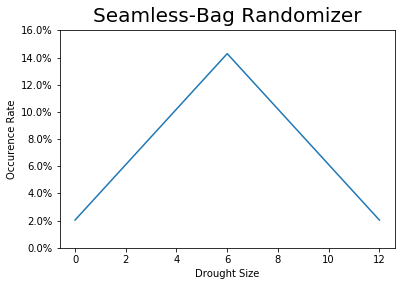

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.72
Branch Perplexity:  4.46
Drought Entropy (Base 13):  0.95
Drought Perplexity:  11.35



In [7]:
def remove_index(graph):
    stable = get_eigenvector(graph, weight='weight')
    new_graph = nx.DiGraph()
    
    # assign new weights to the simpler graph
    for from_node, to_node in graph.edges():
        base_prob = stable[from_node]
        branch_prob = graph.edges[from_node, to_node]['weight']
        drought = graph.edges[from_node, to_node]['drought']

        # make the new state simply an ordered list of droughts
        new_from_node = tuple(from_node.droughts)
        new_to_node = tuple(to_node.droughts)
        
        # weight the branch probability according to the stable state proportion
        weight = base_prob * branch_prob
        
        # if something is already branching there, include that weight also
        if new_graph.has_edge(new_from_node, new_to_node):
            weight += new_graph.edges[new_from_node, new_to_node]['weight']
        
        # add new edge, overwritting if it already exists
        new_graph.add_edge(new_from_node, new_to_node, drought=drought, weight=weight)

    # renormalize the weights to sum to 1
    for from_node in new_graph:
        denominator = 0
        for to_node in nx.neighbors(new_graph, from_node):
            denominator += new_graph.edges[from_node, to_node]['weight']
        for to_node in nx.neighbors(new_graph, from_node):
            new_graph.edges[from_node, to_node]['weight'] /= denominator
    
    return new_graph

Seamless_B7 = copy.deepcopy(B7)
Seamless_B7 = remove_index(B7)
rand_report(Seamless_B7, "Seamless-Bag")

Entropy increases all while the interval curve stays the same, just as predicted. Interestingly, this moves entropy 10% closer to pure random! That's going from having the lowest entropy of any published Tetris game, to being less than random than TGM1 but more random than TGM2 or TGM3.

### Generic Randomizer File Format

This code takes a randomizer graph and turns it into a generic randomizer. It's just a CSV with 3 columns:

* Probability of branching (integer with implied denominator of $12!$)
* Pick index from the list of droughted pieces (increasing order)
* The row of the CSV to jump to, corresponding to a new node / randomizer state

Row 0 is specifically chosen to be the most common state of the graph.

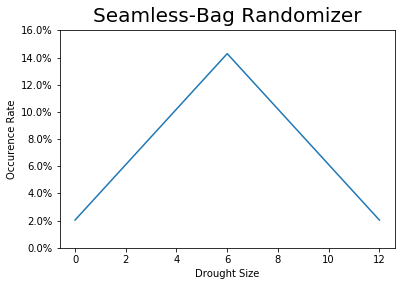

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.72
Branch Perplexity:  4.46
Drought Entropy (Base 13):  0.95
Drought Perplexity:  11.35



In [8]:
def write_rand(graph, name):
    edge_list = list(graph.edges())
    edge_list.sort()
    edge2pick = dict()
    node2index = dict()
    previous_from_node = None
    try:
        i = 0
        for from_node, to_node, key, weight in graph.edges(
                keys=True, data='weight'):
            pick = graph.edges[from_node, to_node, key]['pick']
            edge = tuple([from_node, to_node, key])
            edge2pick[edge] = pick
            if from_node != previous_from_node:
                previous_from_node = from_node
                node2index[from_node] = i
            i += 1
    except TypeError:
        for i, edge in enumerate(edge_list):
            drought = graph.edges[edge]['drought']
            for pick_i, pick in enumerate(edge[0]):
                if pick == drought:
                    edge2pick[edge] = pick_i
            if edge[0] != previous_from_node:
                previous_from_node = edge[0]
                node2index[edge[0]] = i

    # pick a large denominator with many factors
    denominator = math.factorial(12)

    weights = []
    picks = []
    jumps = []
    try:
        for from_node, to_node, key, weight in graph.edges(
                keys=True, data='weight'):
            weight = int(round(weight * denominator, 0))
            pick = graph.edges[from_node, to_node, key]['pick']
            jump = node2index[to_node]
            weights.append(weight)
            picks.append(pick)
            jumps.append(jump)
    except TypeError:
        for i, edge in enumerate(edge_list):
            weight = int(round(graph.edges[edge]['weight'] * denominator, 0))
            pick = edge2pick[edge]
            jump = node2index[edge[1]]
            weights.append(weight)
            picks.append(pick)
            jumps.append(jump)

    # adjust weights, compensating for rounding errors, so that they sum up to the denominator
    nodes = list(node2index.values())
    nodes.append(len(edge_list))
    nodes.sort()
    for i in range(len(nodes) - 1):
        start = nodes[i]
        stop = nodes[i + 1]
        adjustment = denominator - sum(weights[start:stop])
        node_weights = weights[start:stop]
        target = np.argmax(node_weights)
        weights[start + target] += adjustment

    # save the file
    filename = ''.join([name, '.rng'])
    with open(filename, 'w', newline='') as csvfile:
        rand_writer = csv.writer(csvfile, delimiter=',')
        for i in range(len(edge_list)):
            weight = str(weights[i])
            pick = str(picks[i])
            jump = str(jumps[i])
            rand_writer.writerow([weight, pick, jump])


rand_report(Seamless_B7, "Seamless-Bag", save=True)

This code uses the randomizer file to create the specified randomizer.

For initialization, the inital piece map is random and the randomizer state corresponds to row 0 of the CSV.

For piece generation, the generic randomizer keeps track of the piece mapping and steps through the randomzier states per the CSV rules defined above. The piece mapping is simply logic keeping track of an ordered list of most recently to least recently received pieces.

In [9]:
class LoadRandomizer:
    def __init__(self, name):
        """Creates a randomizer from a an .rng file matching the randomizer name."""
        self.piece_map = ['J', 'I', 'Z', 'L', 'O', 'S', 'T']
        self.order = [0, 1, 2, 3, 4, 5, 6]
        random.shuffle(self.order)
        self.state_i = 0
        self.denominator = math.factorial(12)
        self.randomizer = []
        filename = ''.join([name, '.rng'])
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                weight = int(row[0])
                pick = int(row[1])
                jump = int(row[2])
                self.randomizer.append([weight, pick, jump])

    def next_piece(self):
        """Generate a new piece given the randomizer state."""
        roll = random.randrange(1, self.denominator + 1)
        while roll > self.randomizer[self.state_i][0]:
            roll -= self.randomizer[self.state_i][0]
            self.state_i += 1
        pick_index = self.randomizer[self.state_i][1]
        self.state_i = self.randomizer[self.state_i][2]
        pick_piece = self.order[pick_index]
        for i in reversed(range(1, pick_index + 1)):
            self.order[i] = self.order[i - 1]
        self.order[0] = pick_piece
        return self.piece_map[pick_piece]

To test that the above is working, I created a helper function to Monte Carlo the drought distribution. 

Generating test sequence of length 1000000 ...
Sample:
TZOSJLIISLTZOLSJISOTJLZTLIOJSSZTJIOZLJTOSITSJOLZITOSJSZLJTISOIZIOLSJTOIJZOLTSLOZIJSTLOLTZLOITJSLJTZSIOOSJILOZTJOLSTJIZSLJOTSIZLJOTTSOZJLITZIJLSOZTJTILJZTOSILSTZJOJZSOLIZJTOTSTILZTOJTSTJOLIZTSLTOJZIJOSTLJISZOOZTOIJSLZOTZOTISLJSJLZITOSSOZTLJSILOJSTIZIZOTLJISSLTZOLSJISOJTIZLLOTIJZSISOLJTIZSOLJIOZTLSJSILJZTOSIIOJZLSTSJTOILZOTSJJZIJTSLOLZTSLJOISTLJZIOOSLZOTISLJTLZTOISLZJTOTZLISJOTLZSIJOJOSZTLIJLSIOTLJZLOITSLZTOIJTJZILOSJTLZLTOJSIJSZILTZOSJOIJOTZSLIJSOSJITZSOLZSIJLOTJOTILZSJLZSIJTOOLJZTSISTIJOZLTSLZTOJISSZITJLOOZTSLOZISTJIOLZSZOTIZLJOSITSTJIZOLIJZTSIJLOIJLTOSZTILJOITJLZSOTOLSZJIZSTIZJ


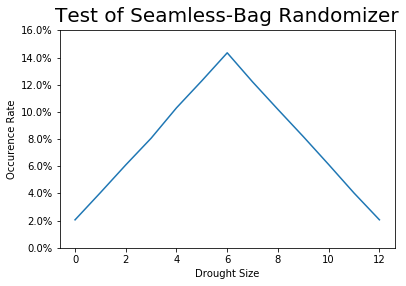

In [10]:
def test_rand(name, n=1000000):
    randomizer = LoadRandomizer(name)
    test_sequence = []
    print("Generating test sequence of length", n, "...")
    for _ in range(n):
        test_sequence.append(randomizer.next_piece())
    print("Sample:")
    print(''.join(test_sequence[0:585]))

    droughts = dict()
    for i in range(13):
        droughts[i] = 0
    current_droughts = dict()
    pieces = "JIZLOST"
    for piece in pieces:
        current_droughts[piece] = 0

    for selection in test_sequence:
        if current_droughts[selection] not in droughts:
            droughts[current_droughts[selection]] = 0
        droughts[current_droughts[selection]] += 1
        for piece in pieces:
            current_droughts[piece] += 1
        current_droughts[selection] = 0

    denominator = sum(droughts.values())
    for key in droughts:
        droughts[key] = droughts[key] / denominator
    plot_counter(droughts, "Test of " + name)


test_rand("Seamless-Bag")

### Chaos 7-bag

Another interesting related randomizer to consider is one with even higher entropy. This one preserves the graph structure of seamless 7-bag, but changes the weights to maximize the entropy.

Naively you might expect maximum entropy when, for a given node, all the edges are equally likely. This is not the case but I will explore it first.

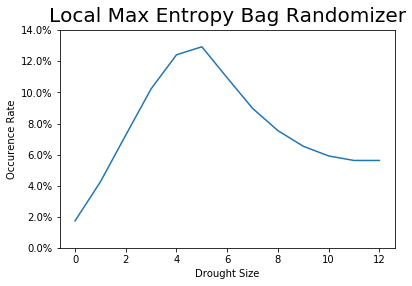

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.7
Branch Perplexity:  4.34
Drought Entropy (Base 13):  0.96
Drought Perplexity:  11.88



In [11]:
def local_max_entropy(graph):
    for from_node in graph:
        denominator = 0
        for to_node in nx.neighbors(graph, from_node):
            denominator += 1
        for to_node in nx.neighbors(graph, from_node):
            graph.edges[from_node, to_node]['weight'] = 1 / denominator
    return graph


Chaos_7B = copy.deepcopy(Seamless_B7)
Chaos_7B = local_max_entropy(Chaos_7B)

rand_report(Chaos_7B, "Local Max Entropy Bag")

The problem with this is that it weights branches into low entropy states (ie. "dead ends") too heavily. So while entropy is locally maximized for a given state, the overall system has a resulting net decrease in entropy.

Fortunately there is an analytic approach to calculating the probability weights of the configuration of maximum entropy of the overall system.

$P_{ij} = \frac{M_{ij}}{\lambda} \times \frac{\psi_{j}}{\psi_{i}}$

Where:
* $P_{ij}$ is the branching probabilities from state $i$ to state $j$
* $M_{ij}$ is the adjacency matrix of the Markov system
* $\lambda$ is the principal eigenvalue of $M_{ij}$
* $\psi_{j}$ and $\psi_{j}$ are the *ith* and *jth* elements of $\lambda$'s eigenvector


In [ ]:
# ignore this code -- it uses a generic optimization technique to maximize the entropy
# a superior, analytic approach follows in the next code cell

def global_max_entropy(graph, ftol=1e-12):
    M = nx.to_scipy_sparse_matrix(
        graph, nodelist=list(graph), weight='weight', dtype=float)

    n_nodes = len(graph)
    n_edges = len(graph.edges())
    node_list = list(graph)
    index2edge = []
    for row in range(n_nodes):
        for i in range(M.indptr[row], M.indptr[row + 1]):
            col = M.indices[i]
            to_node = node_list[col]
            from_node = node_list[row]
            index2edge.append([from_node, to_node])

    def vec2graph(x):
        for i in range(n_edges):
            from_node = index2edge[i][0]
            to_node = index2edge[i][1]
            graph.edges[from_node, to_node]['weight'] = x[i]
        return graph

    # function to minimize
    def neg_entropy(x):
        # state stable proportion
        M.data = copy.deepcopy(x)
        eigenvalue, eigenvector = sp.sparse.linalg.eigs(M.T, k=1, which='LR')
        eigenvector = eigenvector.flatten().real
        eigenvector = eigenvector / eigenvector.sum()

        # state entropy
        for i in range(n_edges):
            try:
                M.data[i] = -M.data[i] * math.log(M.data[i], 2)
            except ValueError:
                M.data[i] = 0
        state_entropy = M.sum(axis=1).squeeze()

        # weighted entropy
        entropy = state_entropy.dot(eigenvector)
        return -entropy

    # constraints
    constraints = []

    def ineq_constraint(x):
        """All edge weights must be >= 0."""
        return x

    constraints.append({'type': 'ineq', 'fun': ineq_constraint})

    def get_constraint(x, node):
        """All nodes must have edges whose weights sum to 1."""
        start = M.indptr[node]
        stop = M.indptr[node + 1]

        def prob_constraint(x):
            return np.sum(x[start:stop]) - 1

        return prob_constraint

    for i in range(n_nodes):
        constraint = get_constraint(M.data, i)
        constraints.append({'type': 'eq', 'fun': constraint})

    # perform the optimization given the constraints
    result = sp.optimize.minimize(
        neg_entropy,
        M.data,
        method='SLSQP',
        constraints=constraints,
        options={'ftol': ftol})
    if result['success'] == False:
        for item in result:
            if item not in ['x', 'jac']:
                print(item, "=", result[item])
        print()

    return vec2graph(result['x'])

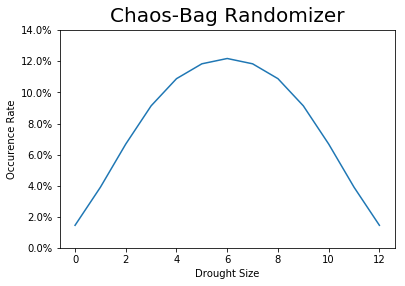

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.74
Branch Perplexity:  4.53
Drought Entropy (Base 13):  0.94
Drought Perplexity:  11.24



In [13]:
def global_max_entropy(graph):
    nodelist = list(graph)
    M = nx.to_scipy_sparse_matrix(
        graph, nodelist=nodelist, weight='weight', dtype=float)
    M.data = np.ones(M.nnz)

    eigenvalue, eigenvector = sp.sparse.linalg.eigs(M, k=1, which='LR')
    eigenvalue = eigenvalue.flatten().real
    eigenvector = eigenvector.flatten().real

    for i in range(M.shape[0]):
        for ind in range(M.indptr[i], M.indptr[i + 1]):
            j = M.indices[ind]
            weight = (M[i, j] * eigenvector[j]) / (eigenvalue * eigenvector[i])
            weight = np.asscalar(weight)
            from_node = nodelist[i]
            to_node = nodelist[j]
            graph.edges[from_node, to_node]['weight'] = weight

    return graph

Chaos_7B = copy.deepcopy(Seamless_B7)
Chaos_7B = global_max_entropy(Chaos_7B)

rand_report(Chaos_7B, "Chaos-Bag", save=True)

### Beyond the 7-bag graph

Even without a bag index, and with maximized entropy, the adjacency matrix of 7-bag imposes a great deal of structure on the resulting sequences. For example, it is possible to receive a piece twice in a row but not 3 times in a row.

Below I explore the full possibility of all possible sequences without breaching a parameterized maximum allowed drought size.

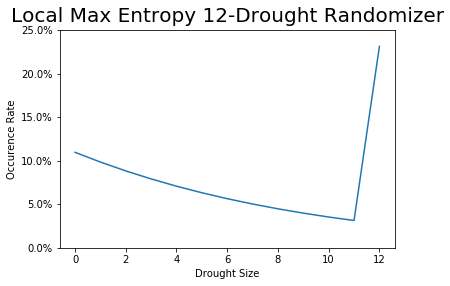

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.77
Branch Perplexity:  5.61
Drought Entropy (Base 13):  0.93
Drought Perplexity:  10.96



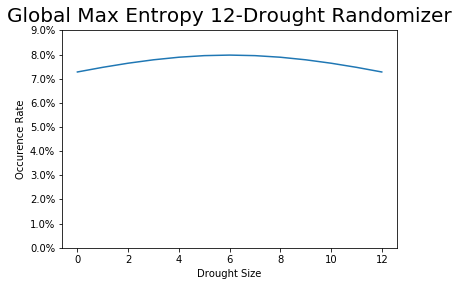

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.85
Branch Perplexity:  5.68
Drought Entropy (Base 13):  1.0
Drought Perplexity:  12.99



In [15]:
def full_graph(drought_max):
    graph = nx.DiGraph()
    state_set = set()
    state_work = list()

    old_state = tuple(range(7))
    state_work.append(old_state)

    while len(state_work) > 0:
        # manage work queue
        old_state = copy.deepcopy(state_work[0])
        state_work.pop(0)
        state_set.add(old_state)
        # explore state transitions
        for roll in range(7):
            new_state = [drought for drought in old_state]
            drought = new_state[roll]
            new_state = [drought + 1 for drought in new_state]
            new_state[roll] = 0
            new_state.sort()

            # detect forbidden state transitions
            if max(new_state) > drought_max:
                continue

            new_state = tuple(new_state)
            graph.add_edge(old_state, new_state, drought=drought)
            if (new_state not in state_set) and (new_state not in state_work):
                state_work.append(new_state)
    return graph


D12 = full_graph(drought_max=12)
D12 = local_max_entropy(D12)
rand_report(D12, "Local Max Entropy 12-Drought")
D12 = global_max_entropy(D12)
rand_report(D12, "Global Max Entropy 12-Drought")

### A bunch of haphazard randomizer experiments

In [16]:
def wedge_droughts(graph):
    M = nx.to_scipy_sparse_matrix(
        graph, nodelist=list(graph), weight='weight', dtype=float)

    n_nodes = len(graph)
    n_edges = len(graph.edges())
    node_list = list(graph)
    index2edge = []
    for row in range(n_nodes):
        for i in range(M.indptr[row], M.indptr[row + 1]):
            col = M.indices[i]
            to_node = node_list[col]
            from_node = node_list[row]
            index2edge.append([from_node, to_node])

    def vec2graph(x):
        for i in range(n_edges):
            from_node = index2edge[i][0]
            to_node = index2edge[i][1]
            graph.edges[from_node, to_node]['weight'] = x[i]
        return graph

    # function to minimize
    def wedge(x):
        graph = vec2graph(x)
        stable = get_eigenvector(graph, weight='weight')
        droughts = get_drought_dist(graph, stable)
        L2_error = 0
        n_droughts = len(droughts)
        for drought in droughts:
            L2_error += (droughts[drought] - (7 - abs(drought - 6)) / 49)**2
        return L2_error

    # constraints
    constraints = []

    def ineq_constraint(x):
        """All edge weights must be >= 0."""
        return x

    constraints.append({'type': 'ineq', 'fun': ineq_constraint})

    def get_constraint(x, node):
        """All nodes must have edges whose weights sum to 1."""
        start = M.indptr[node]
        stop = M.indptr[node + 1]

        def prob_constraint(x):
            return np.sum(x[start:stop]) - 1

        return prob_constraint

    for i in range(n_nodes):
        constraint = get_constraint(M.data, i)
        constraints.append({'type': 'eq', 'fun': constraint})

    # perform the optimization given the constraints
    result = optimize.minimize(
        wedge,
        M.data,
        method='SLSQP',
        constraints=constraints,
        options={'ftol': 1e-12})
    if result['success'] == False:
        for item in result:
            if item not in ['x', 'jac']:
                print(item, "=", result[item])
        print()

    return vec2graph(result['x'])


def remove_droughts(graph, forbidden):

    # remove edges matching drought criteria
    junk = []
    for from_node, to_node in graph.edges():
        drought = graph.edges[from_node, to_node]['drought']
        if drought in forbidden:
            junk.append((from_node, to_node))
            
    graph = remove_edges(graph, junk)
    return graph

def remove_edges(graph, junk_edges):
    # remove junk edges
    for from_node, to_node in junk_edges:
        graph.remove_edge(from_node, to_node)

    # remove any orphaned nodes if applicable
    connected = max(nx.strongly_connected_components(graph), key=len)
    junk_nodes = set()
    for node in graph:
        if node not in connected:
            junk_nodes.add(node)
    for node in junk_nodes:
        graph.remove_node(node)
        
    # re-weight
    for from_node in graph:
        denominator = 0
        for to_node in nx.neighbors(graph, from_node):
            denominator += graph.edges[from_node, to_node]['weight']
        for to_node in nx.neighbors(graph, from_node):
            graph.edges[from_node, to_node]['weight'] /= denominator

    return graph

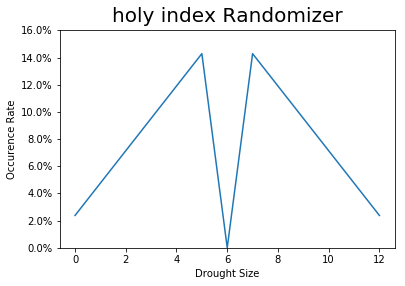

Number of randomizer states (nodes): 125
Number of state transitions (edges): 374
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.55
Branch Perplexity:  3.46
Drought Entropy (Base 13):  0.92
Drought Perplexity:  10.54



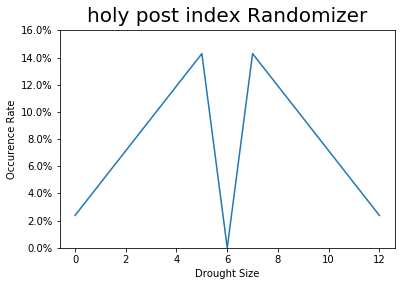

Number of randomizer states (nodes): 64
Number of state transitions (edges): 224
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.65
Branch Perplexity:  3.85
Drought Entropy (Base 13):  0.92
Drought Perplexity:  10.54



In [17]:
test = copy.deepcopy(B7)
test = remove_droughts(test, [6])
test = global_max_entropy(test)
rand_report(test, "holy index")
test = remove_index(test)
rand_report(test, "holy post index")

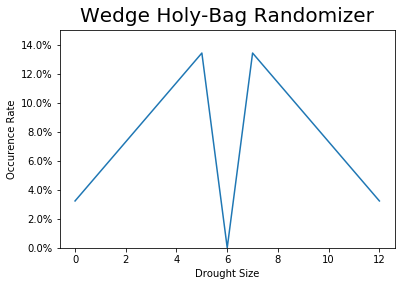

Number of randomizer states (nodes): 64
Number of state transitions (edges): 224
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.65
Branch Perplexity:  3.84
Drought Entropy (Base 13):  0.93
Drought Perplexity:  10.94



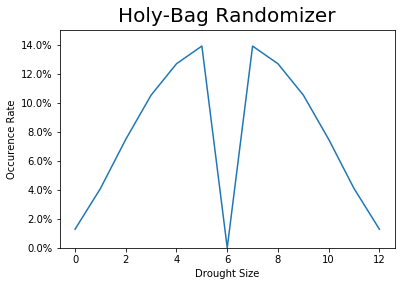

Number of randomizer states (nodes): 64
Number of state transitions (edges): 224
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.68
Branch Perplexity:  4.0
Drought Entropy (Base 13):  0.9
Drought Perplexity:  10.06



In [18]:
holy_bag = copy.deepcopy(Seamless_B7)
holy_bag = remove_droughts(holy_bag, [6])
holy_bag = wedge_droughts(holy_bag)
rand_report(holy_bag, "Wedge Holy-Bag")

holy_bag = global_max_entropy(holy_bag)
rand_report(holy_bag, "Holy-Bag", save=True)

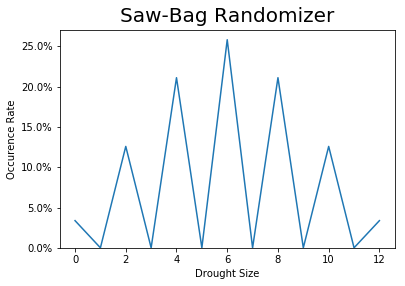

Number of randomizer states (nodes): 35
Number of state transitions (edges): 80
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.46
Branch Perplexity:  2.59
Drought Entropy (Base 13):  0.68
Drought Perplexity:  5.79



In [19]:
saw_bag = copy.deepcopy(Seamless_B7)
saw_bag = remove_droughts(saw_bag, [1, 3, 5, 7, 9, 11])
saw_bag = global_max_entropy(saw_bag)
rand_report(saw_bag, "Saw-Bag", save=True)

In [20]:
def flat_droughts(graph):
    M = nx.to_scipy_sparse_matrix(
        graph, nodelist=list(graph), weight='weight', dtype=float)

    n_nodes = len(graph)
    n_edges = len(graph.edges())
    node_list = list(graph)
    index2edge = []
    index2drought = []
    for row in range(n_nodes):
        for i in range(M.indptr[row], M.indptr[row + 1]):
            col = M.indices[i]
            to_node = node_list[col]
            from_node = node_list[row]
            drought = graph.edges[from_node, to_node]['drought']
            index2edge.append([from_node, to_node])
            index2drought.append(drought)

    def vec2graph(x, prune=True):
        junk = []
        for i in range(n_edges):
            from_node = index2edge[i][0]
            to_node = index2edge[i][1]
            graph.edges[from_node, to_node]['weight'] = x[i]
            if int(round(x[i] * math.factorial(12), 0)) == 0:
                junk.append((from_node, to_node))
        if prune == True:
            remove_edges(graph, junk)
        return graph

    # function to minimize
    def flat(x):
        M.data = copy.deepcopy(x)
        eigenvalue, eigenvector = sp.sparse.linalg.eigs(M.T, k=1, which='LR')
        eigenvector = eigenvector.flatten().real
        eigenvector = eigenvector / eigenvector.sum()
        branch_weights = M.T.multiply(eigenvector)
    
        droughts = np.zeros(13)
        for i in range(len(x)):
            drought = index2drought[i]
            droughts[drought] += branch_weights.data[i]

        drought_entropy = 0
        for i in range(13):
            try:
                droughts[i] = -droughts[i] * math.log2(droughts[i])
            except ValueError:
                droughts[i] = 0
        drought_entropy = droughts.sum()
        
        return -drought_entropy

    # constraints
    constraints = []

    def ineq_constraint(x):
        """All edge weights must be >= 0."""
        return x

    constraints.append({'type': 'ineq', 'fun': ineq_constraint})

    def get_constraint(x, node):
        """All nodes must have edges whose weights sum to 1."""
        start = M.indptr[node]
        stop = M.indptr[node + 1]

        def prob_constraint(x):
            return np.sum(x[start:stop]) - 1

        return prob_constraint

    for i in range(n_nodes):
        constraint = get_constraint(M.data, i)
        constraints.append({'type': 'eq', 'fun': constraint})

    # perform the optimization given the constraints
    result = optimize.minimize(
        flat,
        M.data,
        method='SLSQP',
        constraints=constraints,
        options={'ftol': 1e-12})
    if result['success'] == False:
        for item in result:
            if item not in ['x', 'jac']:
                print(item, "=", result[item])
        print()

    return vec2graph(result['x'])

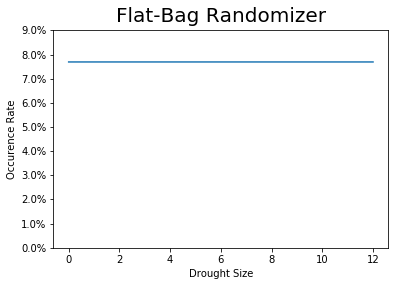

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.48
Branch Perplexity:  2.67
Drought Entropy (Base 13):  1.0
Drought Perplexity:  13.0



In [21]:
flat_bag = copy.deepcopy(Seamless_B7)
flat_bag = flat_droughts(flat_bag)
rand_report(flat_bag, "Flat-Bag", save=True)

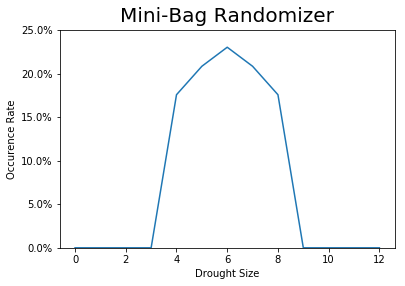

Number of randomizer states (nodes): 6
Number of state transitions (edges): 12
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.44
Branch Perplexity:  2.48
Drought Entropy (Base 13):  0.63
Drought Perplexity:  4.97



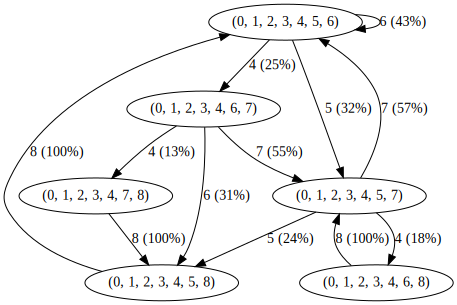

In [22]:
def plot_graph(state_graph):
    G = graphviz.Digraph()
    G.attr(size='10')
    G.attr('node', shape='oval')
    for from_node, to_node in state_graph.edges():
        G.edge(
            str(from_node),
            str(to_node),
            label=str(state_graph.edges[from_node, to_node]['drought']) + " ("
            + str(
                int(
                    round(100 * state_graph.edges[from_node, to_node]['weight']
                          ))) + "%)")
    return G


mini_bag = copy.deepcopy(Seamless_B7)
mini_bag = remove_droughts(mini_bag, [0, 1, 2, 3, 9, 10, 11, 12])
mini_bag = global_max_entropy(mini_bag)
rand_report(mini_bag, "Mini-Bag", save=True)
plot_graph(mini_bag)

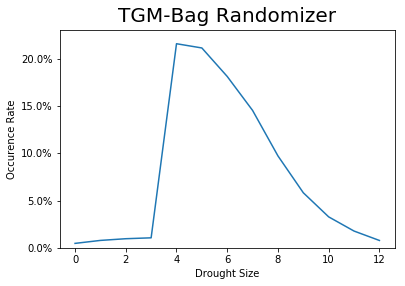

Number of randomizer states (nodes): 64
Number of state transitions (edges): 256
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.6
Branch Perplexity:  3.26
Drought Entropy (Base 13):  0.79
Drought Perplexity:  7.52



In [23]:
tgm_bag = copy.deepcopy(Seamless_B7)

# give maximum entropy weights
for from_node in tgm_bag:
    denominator = 0
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            denominator += 0.01
        elif tgm_bag.edges[from_node, to_node]['drought'] <= 5:
            denominator += 1.5 * tgm_bag.edges[from_node, to_node]['weight']
        else:
            denominator += tgm_bag.edges[from_node, to_node]['weight']
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            tgm_bag.edges[from_node, to_node]['weight'] = 0.01 / denominator
        elif tgm_bag.edges[from_node, to_node]['drought'] <= 5:
            tgm_bag.edges[from_node, to_node]['weight'] = 1.5 * \
                tgm_bag.edges[from_node, to_node]['weight']/denominator
        else:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] / denominator

rand_report(tgm_bag, "TGM-Bag", save=True)

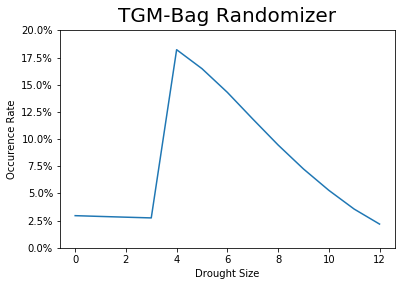

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.75
Branch Perplexity:  4.36
Drought Entropy (Base 13):  0.9
Drought Perplexity:  10.13



In [24]:
tgm_bag = copy.deepcopy(D12)

suppression = 0.02

# give maximum entropy weights
for from_node in tgm_bag:
    denominator = 0
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            denominator += suppression
        else:
            denominator += tgm_bag.edges[from_node, to_node]['weight']
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            tgm_bag.edges[from_node, to_node]['weight'] = suppression / denominator
        else:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] / denominator

rand_report(tgm_bag, "TGM-Bag")

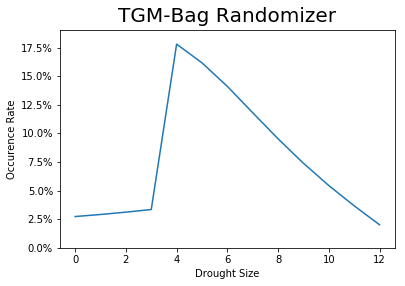

Number of randomizer states (nodes): 924
Number of state transitions (edges): 3696
Sum of drought interval probabilities:  100.0 %
Branch Entropy (Base 7):  0.75
Branch Perplexity:  4.43
Drought Entropy (Base 13):  0.91
Drought Perplexity:  10.26



In [25]:
tgm_bag = full_graph(drought_max=12)
tgm_bag = global_max_entropy(tgm_bag)

suppression = 0.20

# give maximum entropy weights
for from_node in tgm_bag:
    denominator = 0
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            denominator += tgm_bag.edges[from_node,
                                         to_node]['weight'] * suppression
        else:
            denominator += tgm_bag.edges[from_node, to_node]['weight']
    for to_node in nx.neighbors(tgm_bag, from_node):
        if tgm_bag.edges[from_node, to_node]['drought'] <= 3:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] * suppression / denominator
        else:
            tgm_bag.edges[from_node, to_node]['weight'] = tgm_bag.edges[
                from_node, to_node]['weight'] / denominator

rand_report(tgm_bag, "TGM-Bag")

This one should violate any sort of "all nodes could be any permutation of drought order" test.

Generating test sequence of length 10000000 ...
Sample:
OTSSTZLTTSTTILIIJSZJLSSSZZSLOTJZTILOSZJZOLSOZIZSLOJOITJLTJTSJTLISTITSLIJITTZLOZJOTJLIOSIZZLZTSJTZLIOZTOTLIOOSITLOOIIITLITJSJSLSSTJTILITSSISLZZSTJSLJOSJISLZZSOJOLJSZITSLSOJSITLIJJOOSLZTZIZJLSZSJTILZZZJOOLOTIOZOLOTITOZLJOOIZSLSJOJSZLSZOZITLTZSSOTLOZITZZLIOSIJILTIZJJSLOJJZOTLZOOZOOLIIOIJJLOJIISILSTTSITLZZTOIOLOTOIIOLSJIITTLTJSZIZLIJZJTILTJOTOOLOISSOSLJTTSITLJSJTTTLSZTSTJLTZIIZJLITSZTILZITOOILOZZJZZLZJIOSZLZZJZSILSIIIISLITOJSTLSSZOJTLZOZTJILJSSOZJLSOOZOOLISOSOTLIOJSOSLSTIOTJLZZZIIILZSJSTILTIIIOZLJOOZJOLZOSTISLTTSSJZLSJTTIILJOOJZTLJZSJOOLOIZTTOLOTIJZOLSTZZJZLTTSSTILOOJOTSLOSTTZOLZSIO


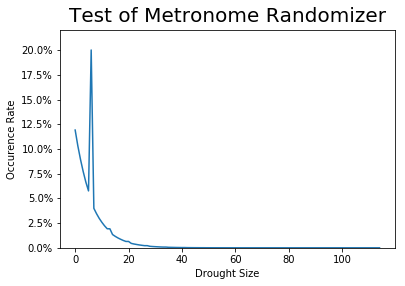

In [26]:
Metronome = nx.MultiDiGraph()
state_set = set()
state_work = list()

old_state = [0, 0]
state_work.append(old_state)

while len(state_work) > 0:
    # manage work queue
    old_state = copy.deepcopy(state_work[0])
    state_work.pop(0)
    state_set.add(tuple(old_state))
    # explore state transitions
    for roll in range(7):
        new_state = copy.deepcopy(old_state)
        counter = old_state[1]
        metro_i = old_state[0]
        if roll == metro_i:
            if counter == 6:
                new_state = [0, 0]
                Metronome.add_edge(
                    tuple(old_state), tuple(new_state), pick=roll, weight=1)
            continue
        elif counter == 6:
            continue
        elif roll > metro_i:
            new_state[0] = metro_i + 1
        new_state[1] = counter + 1

        Metronome.add_edge(
            tuple(old_state), tuple(new_state), pick=roll, weight=1 / 6)
        if (tuple(new_state) not in state_set) and (
                new_state not in state_work):
            state_work.append(new_state)

# rand_report(Metronome, "Metronome")
write_rand(Metronome, "Metronome")
test_rand("Metronome", n=10000000)